# AI Project - Phase 2 (Destination Suggestion)
<div style="text-align: center">
<h1 style = "color: red"> Sharif University Of Technology</h1>
<h2 style = "color: green"> DR. Mahdieh Soleymani | DR. MohammadHossein Rohban </h2>
<h3 style = "color: cyan"> Head of Project: AmirHossein Razlighi <h3>
<h3 style = "color: cyan"> Designed By: AmirHossein Razlighi, Javad Hezareh, Payam Taebi, Alireza Sakhaei, Ali Banayeean, Yalda Shabanzadeh, Hamidreza Yaghoubi, Alireza Heidari <h3>
</div>

## Overview

<div style="text-align: center">
<img src="./images/Uber_research.jpg" width="100%" height="auto" />
</div>

Suppose you are a research engineer at Uber and you are asked to design a system that suggests destinations to the passengers. The system should be able to suggest destinations based on the passenger's history. For example, one passenger may save a variety of locations (like home, work, gym, etc.). This passenger may go to gym, often on weekends and when he/she requests a car from Home. 

So, for example, if I am a student, going to university usually from Saturday to Wednesday on 8:00 from "home", the next time I request a car from "home" on 8:00, the system should suggest "university" as the destination. Now, it's not that simple always, so we should seek for smart wayys to solve this problem!

As you may understood by now, we should engineer some of features from the data we have and try to predict the next destination of the passenger.

Let's begin!

## Setup

In [1]:
import random
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm

random.seed(2024)
np.random.seed(2024)

# First Approach: Using KNN

## Data Preparation for KNN

In this part, you should prepare the data for KNN. You should load the dataset file that we provided, named `Data/output.json` and then clean it, do all the required preprocessings and then split into train-test-val sets if necessary. Note that we provided a splitted test set for you, named `Data/output_test.json`. You should not use this file for training or validation. You should only use it for testing your model.

In [2]:
df = pd.read_json("datasets/output.json")
df["start_time"] = pd.to_datetime(df["start_time"], format="%H:%M:%S").dt.time
df["end_time"] = pd.to_datetime(df["end_time"], format="%H:%M:%S").dt.time
df.head()

,user_id,Day,origin lat,origin lon,dest lat,dest lon,start_time,end_time,price
0,0,0,35.625,51.375,36.000,51.085,13:07:00,14:43:00,43.99
1,0,0,36.000,51.085,35.625,51.375,15:13:00,16:49:00,36.66
2,0,0,35.680,51.445,35.745,51.465,20:41:00,20:54:00,15.08
3,0,0,35.745,51.465,35.680,51.445,21:24:00,21:37:00,10.00
4,0,1,35.625,51.375,35.680,51.445,23:38:00,23:58:00,19.48


In [3]:
test_df = pd.read_json("datasets/output_test.json")
test_df["start_time"] = pd.to_datetime(test_df["start_time"], format="%H:%M:%S").dt.time
test_df["end_time"] = pd.to_datetime(test_df["end_time"], format="%H:%M:%S").dt.time
test_df.head()

,user_id,Day,origin lat,origin lon,dest lat,dest lon,start_time,end_time,price
0,24,6,35.650,51.225,35.640,51.270,11:58:00,12:12:00,10.00
1,46,2,35.625,51.250,35.690,51.295,21:58:00,22:18:00,11.84
2,27,5,35.650,51.225,35.865,51.045,20:05:00,20:58:00,23.36
3,7,4,35.875,51.375,35.890,51.315,17:39:00,18:17:00,13.74
4,27,3,35.625,51.375,35.650,51.385,13:16:00,13:19:00,15.08


In [4]:
# print out the number of unique users and also randomly select one user
num_users = df["user_id"].nunique()
selected_user = df["user_id"].sample().iloc[0]
num_users, selected_user

(60, 50)

In [5]:
from keplergl import KeplerGl

# Uncomment the following line if you are using Google Colab
# from google.colab import output
# output.enable_custom_widget_manager()

In [6]:
# choose the data related to the randomly selected user
# show destinations of this user on map
# You should Use Kepler.gl to visualize the data

user_df = df[df["user_id"] == selected_user]
user_df.head()

,user_id,Day,origin lat,origin lon,dest lat,dest lon,start_time,end_time,price
14698,50,0,35.905,51.035,35.875,51.125,06:57:00,07:14:00,19.38
14699,50,0,35.875,51.125,35.975,51.250,17:12:00,17:43:00,23.11
14700,50,1,35.975,51.250,35.875,51.125,06:28:00,07:03:00,17.73
14701,50,1,35.875,51.125,35.945,51.170,13:49:00,14:03:00,10.00
14702,50,1,35.945,51.170,35.875,51.125,14:33:00,14:54:00,10.00


In [7]:
# Sample output:
visualized_trip = KeplerGl(height=400, data = {"destinations": user_df[["dest lat", "dest lon"]]})
visualized_trip

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'destinations':        dest lat  dest lon
14698    35.875    51.125
14699    35.975    51.250
1…

Here, you should do feature engineering stuff! Extract the features that you think are important. Split the features into training set and also extract the related outputs (used for our model further). These outputs may be strings (name of destination) or destination's latitude/longitude or etc. Use your creativity!

In [8]:
from sklearn.preprocessing import StandardScaler

df["start_time"] = df["start_time"].apply(lambda x: x.hour * 60 + x.minute)
test_df["start_time"] = test_df["start_time"].apply(lambda x: x.hour * 60 + x.minute)

features = ["user_id", "Day", "origin lat", "origin lon", "start_time"]
outputs = ["dest lat", "dest lon"]

train_X = df[features]
train_y = df[outputs]

test_X = test_df[features]
test_y = test_df[outputs]

scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

train_y_scaled = train_y.to_numpy()
test_y_scaled = test_y.to_numpy()

In [9]:
# print out the shape of the train and test dataframes
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((17994, 5), (17994, 2), (4499, 5), (4499, 2))

## KNN Model

In this section, we are going to implement our KNN model. For further information on how KNN works, please refer to [this](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) link. As you can see, it's a simple algorithm. We will start with this and see the results of our _destination suggestion_ system.

In [10]:
# Define the model

class NearestNeighbor():
    def __init__(self, k=3):
        self.k = k
        self.train_X = None
        self.train_y = None
    
    def euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def fit(self, train_X, train_y):
        self.train_X = train_X
        self.train_y = train_y

    def predict(self, test_X):
        distances = [self.euclidean_distance(test_X, x) for x in self.train_X]
        k_idx = np.argsort(distances)[:self.k]
        k_labels = [list(self.train_y[i]) for i in k_idx]
        return max(k_labels, key=k_labels.count)

In [11]:
# Fit the model on training data
knn = NearestNeighbor()
knn.fit(train_X_scaled, train_y_scaled)

In [12]:
# Calculate the accuracy on training data
pred_y = []
for x in tqdm(train_X_scaled):
    pred_y.append(knn.predict(x))
    
accuracy = sum(np.all(train_y_scaled == pred_y, axis=1)) / len(train_y_scaled)
accuracy

100%|██████████| 17994/17994 [12:48<00:00, 23.41it/s]


0.9179726575525176

In [13]:
# Calculate the accuracy on test data
pred_y = []
for x in tqdm(test_X_scaled):
    pred_y.append(knn.predict(x))
    
accuracy = sum(np.all(test_y_scaled == pred_y, axis=1)) / len(test_y_scaled)
accuracy

100%|██████████| 4499/4499 [03:12<00:00, 23.35it/s]


0.4661035785730162

**QUESTION**: What do you think about this approach? Is it a good idea to use KNN for this problem? Why (or why not)? If the patterns in our datatset (passengers' history) get more complicated, will our model be robust to it in comparison to other models?

Your Answer: As we know k-NN is a lazy learner and it doesn't learn a function so that we can predict labels with it. It also doesn't perform well when our dataset is too large or too noisy. Inputs in this problem are a bit complicated and they have many features so, i think that k-NN is not a good approach that we have taken for this problem. We also can see from the calculated accuracies that it doesn't even perform well on this simple dataset that we have, so the results will definitely be worse if we use a more complicated dataset.

# Second Approach: Using XGBoost

In this part, we are going to use XGBoost to predict the next destination of the passenger. You can use `xgboost` library to implement this model. To learn more about XGBoost, please refer to [this](https://en.wikipedia.org/wiki/XGBoost) link. It should be familiar to you, as you saw decision trees in the class.

For this part, you can use the same data (that you did all the processes on) from the previous part. Or, if you need, you can reload the dataset and do new preprocessings on it.

You can see the overview of how XGBoost works in the image below:

<dev style="text-align: center">
<img src="./images/XGBoost.png" />
</dev>

Although, this is for more information and you **do not** need to implement `XGBoost` from scratch. You can use the library that we mentioned above.

In [14]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [15]:
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

# Defining the model

class Encoder():
    def __init__(self):
        self.encoders = {}

    def fit(self, y):
        for col in y.columns:
            col_enc = LabelEncoder()
            col_enc.fit(y[col])
            self.encoders[col] = col_enc
                
    def transform(self, y):
        y_enc = y.copy()
        for col, encoder in self.encoders.items():
            y_enc[col] = encoder.transform(y[col])
        return y_enc

    def inverse_transform(self, y):
        y_dec = y.copy()
        for col, encoder in self.encoders.items():
            y_dec[col] = encoder.inverse_transform(y[col])
        return y_dec

In [16]:
encoder = Encoder()

train_y_com = pd.DataFrame(train_y.apply(lambda x: f"{x['dest lat']}_{x['dest lon']}", axis=1), columns=["dest"])
test_y_com = pd.DataFrame(test_y.apply(lambda x: f"{x['dest lat']}_{x['dest lon']}", axis=1), columns=["dest"])
encoder.fit(train_y_com)

train_y_enc = encoder.transform(train_y_com).to_numpy()
test_y_enc = encoder.transform(test_y_com).to_numpy()

In [17]:
# transform the training and test data
# and fit the model on training data
train_X_enc = train_X_scaled
test_X_enc = test_X_scaled

classifier = xgb.XGBClassifier()
classifier.fit(train_X_enc, train_y_enc)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [18]:
# print out train-data accuracy
accuracy = classifier.score(train_X_enc, train_y_enc)
accuracy

0.9392019562076248

In [19]:
# print out test-data accuracy
accuracy = classifier.score(test_X_enc, test_y_enc)
accuracy

0.659924427650589

**QUESTION**: What do you think about this approach? Is it a good idea to use XGBoost for this problem? Why (or why not)? If the patterns in our dataset (passengers' history) get more complicated, will our model be robust to it in comparison to other models?

Your Answer: It's clear from the accuracies that XGBoost is a much more reliable way to solve this problem than the k-NN. It can handle a much more complicated dataset and we can most of the times encode our labels to make them proper for XGBoost. But the problem that XGBoost has is overfitting. Even though its accuracy is much higher on the test set compared to k-NN, we still can see there is a big gap between train set and test set accuracies.

**Question**: Please explain the problem of overfitting in XGBoost. How can you solve it? Provide a brief explanation.

Your Answer: So we know that XGBoost is a combination of decision trees and gradient descent methods. We create a decision tree for the errors in every iteration and then we add it to the previous ones. In this step we include a factor called learning rate and we multiply the newly created tree by it before adding the tree to the previous ones. With this factor we can make the steps that are taken towards the goal smaller and by that we can prevent overfitting to some levels. Another factor that causes the overfitting is the depth of the three that we create in every iteration. We know it from the decision trees that if we create a quite deep tree to predict our model we will probably have overfitting problems, So we can also choose a proper depth for our trees to further prevent overfitting.

Overall even though we have some ways to prevent our model to overfit, there are some models and levels of complexity that none of the mentioned ways are enough to prevent the overfitting problem. We will either have pretty bad predications and result or we will overfit. 

# Third Approach: Classifier Using Neural Networks

In this approach, we are going to use a classifier using neural networks. You can think of this approach and how to model the problem as a classification problem in many ways! So, we are not going to restrict your creativity. Just a hint: You can consider each of the unique destinations (in whole dataset) as a class and then train a classifier to classify the destinations.

## Data for Neural Network

Let's prepare the data for our neural network. Again, you should extract required features from the dataset and then split the dataset into train-test-val sets if necessary. For your ease, we prepared another version of `output.json` that helps you to extract features for this part, easier. So, please load `Data/trip_data.json` and use it for training set and validation set. You should use `Data/trip_data_test.json` for testing your model.

In [20]:
# load the training dataset
df = pd.read_json("datasets/trip_data.json")
df["start_time"] = pd.to_datetime(df["start_time"], format="%H:%M:%S").dt.time
df["end_time"] = pd.to_datetime(df["end_time"], format="%H:%M:%S").dt.time
df.head()

,user_id,Day,origin,destination,start_time,end_time,price
0,0,0,"[work, [35.625, 51.375]]","[restaurant, [36.0, 51.085]]",13:07:00,14:43:00,43.99
1,0,0,"[restaurant, [36.0, 51.085]]","[work, [35.625, 51.375]]",15:13:00,16:49:00,36.66
2,0,0,"[home, [35.68, 51.445]]","[restaurant, [35.745, 51.465]]",20:41:00,20:54:00,15.08
3,0,0,"[restaurant, [35.745, 51.465]]","[home, [35.68, 51.445]]",21:24:00,21:37:00,10.00
4,0,1,"[work, [35.625, 51.375]]","[home, [35.68, 51.445]]",23:38:00,23:58:00,19.48


In [21]:
# load the test dataset
test_df = pd.read_json("datasets/trip_data_test.json")
test_df["start_time"] = pd.to_datetime(test_df["start_time"], format="%H:%M:%S").dt.time
test_df["end_time"] = pd.to_datetime(test_df["end_time"], format="%H:%M:%S").dt.time
test_df.head()

,user_id,Day,origin,destination,start_time,end_time,price
0,24,6,"[pool, [35.65, 51.225]]","[home, [35.64, 51.27]]",11:58:00,12:12:00,10.00
1,46,2,"[university, [35.625, 51.25]]","[restaurant, [35.69, 51.295]]",21:58:00,22:18:00,11.84
2,27,5,"[pool, [35.65, 51.225]]","[restaurant, [35.865, 51.045]]",20:05:00,20:58:00,23.36
3,7,4,"[work, [35.875, 51.375]]","[home, [35.89, 51.315]]",17:39:00,18:17:00,13.74
4,27,3,"[work, [35.625, 51.375]]","[restaurant, [35.65, 51.385]]",13:16:00,13:19:00,15.08


In [22]:
# Extract features and do preprocessing if needed
combined_origin = df["origin"].values
combined_dest = df["destination"].values
origin = []
for co in combined_origin:
    origin.append(f"{co[0]}_{co[1][0]}_{co[1][1]}")
df["origin"] = origin
dest = []
for cd in combined_dest:
    dest.append(f"{cd[0]}")
df["destination"] = dest

df["start_time"] = df["start_time"].apply(lambda x: x.hour * 60 + x.minute)
df["end_time"] = df["end_time"].apply(lambda x: x.hour * 60 + x.minute)

features = ["user_id", "Day", "origin", "start_time"]
outputs = ["destination"]

train_X = df[features]
train_y = df[outputs]

train_X.head()

,user_id,Day,origin,start_time
0,0,0,work_35.625_51.375,787
1,0,0,restaurant_36.0_51.085,913
2,0,0,home_35.68_51.445,1241
3,0,0,restaurant_35.745_51.465,1284
4,0,1,work_35.625_51.375,1418


In [23]:
# Extract features and do preprocessing if needed
combined_origin = test_df["origin"].values
combined_dest = test_df["destination"].values
origin = []
for co in combined_origin:
   origin.append(f"{co[0]}_{co[1][0]}_{co[1][1]}")
test_df["origin"] = origin
dest = []
for cd in combined_dest:
    dest.append(f"{cd[0]}")
test_df["destination"] = dest

test_df["start_time"] = test_df["start_time"].apply(lambda x: x.hour * 60 + x.minute)
test_df["end_time"] = test_df["end_time"].apply(lambda x: x.hour * 60 + x.minute)


features = ["user_id", "Day", "origin", "start_time"]
outputs = ["destination"]

test_X = test_df[features]
test_y = test_df[outputs]

test_X.head()

,user_id,Day,origin,start_time
0,24,6,pool_35.65_51.225,718
1,46,2,university_35.625_51.25,1318
2,27,5,pool_35.65_51.225,1205
3,7,4,work_35.875_51.375,1059
4,27,3,work_35.625_51.375,796


In [24]:
# print out the unique values for each column
for col in df.columns:
    print(f"Column: {col}\nUnique values: {sorted(df[col].unique())}\n========================================")

Column: user_id
Unique values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]
Column: Day
Unique values: [0, 1, 2, 3, 4, 5, 6]
Column: origin
Unique values: ['gym_35.525_51.46', 'gym_35.55_51.165', 'gym_35.575_51.245', 'gym_35.8_51.1', 'gym_35.975_51.25', 'home_35.505_51.06', 'home_35.535_51.305', 'home_35.53_51.485', 'home_35.545_51.095', 'home_35.545_51.145', 'home_35.54_51.075', 'home_35.555_51.18', 'home_35.595_51.475', 'home_35.5_51.29', 'home_35.615_51.175', 'home_35.62_51.275', 'home_35.635_51.39', 'home_35.635_51.47', 'home_35.64_51.25', 'home_35.64_51.27', 'home_35.675_51.25', 'home_35.68_51.215', 'home_35.68_51.445', 'home_35.69_51.12', 'home_35.71_51.09', 'home_35.735_51.2', 'home_35.745_51.465', 'home_35.76_51.435', 'home_35.775_51.4', 'home_35.77_51.245', 'home_35.785_51.435', 'home_35.7_51.1

In [25]:
import pandas as pd

# print out the data type of each column
print("DataFrame Column Head and Data Type:\n========================================")
for col in df.columns:
    print(f"Column: {col}\nData Type: {df[col].dtype}\n----------------------------------------")

DataFrame Column Head and Data Type:
Column: user_id
Data Type: int64
----------------------------------------
Column: Day
Data Type: int64
----------------------------------------
Column: origin
Data Type: object
----------------------------------------
Column: destination
Data Type: object
----------------------------------------
Column: start_time
Data Type: int64
----------------------------------------
Column: end_time
Data Type: int64
----------------------------------------
Column: price
Data Type: float64
----------------------------------------


Based on your features and how you extracted them, you may need to use some encodings for your data. For example, if you have different classes as names (`str` data type. E.g. "gym") you need to make it a numeric value in order to feed it into your neural network. You can use `sklearn`'s functions (such as `LabelEncoder`, `OneHotEncoder`, `StandardScaler`, etc.) to do these kind of stuff!

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder

# Finalize the data (do all preprocessing needed)
train_X_enc = train_X.copy()
test_X_enc = test_X.copy()

train_y_enc = train_y.copy()
test_y_enc = test_y.copy()

label_enc = LabelEncoder()
train_X_enc["origin"] = label_enc.fit_transform(train_X["origin"])
test_X_enc["origin"] = label_enc.transform(test_X["origin"])

train_y_enc["destination"] = label_enc.fit_transform(train_y["destination"])
test_y_enc["destination"] = label_enc.transform(test_y["destination"])

scaler = StandardScaler()
train_X_enc = pd.DataFrame(scaler.fit_transform(train_X_enc), columns=train_X_enc.columns)
test_X_enc = pd.DataFrame(scaler.transform(test_X_enc), columns=test_X_enc.columns)

train_X_enc, val_X_enc, train_y_enc, val_y_enc = train_test_split(train_X_enc, train_y_enc, test_size=0.2)

Create `train_dataset` and its loader, also create `test_dataset` and its loader. You should also create `val_dataset` and its loader if you want to use validation set. You may need to implement a custom `torch.Dataset` class for your ease. Your loaders should be able to load data in batches.

In [27]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

class SparseDataset(Dataset):
    def __init__(self, X, y, device="cpu"):
        self.X = torch.tensor(X.to_numpy(), dtype=torch.float32, device=device)
        self.y = torch.tensor(y.to_numpy(), dtype=torch.int64, device=device)

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = SparseDataset(train_X_enc, train_y_enc["destination"])
val_dataset = SparseDataset(val_X_enc, val_y_enc["destination"])
test_dataset = SparseDataset(test_X_enc, test_y_enc["destination"])

# Batch size
batch_size = 64

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Neural Network Model

Here, you should implement your neural network model. You should use `pytorch`. **Note** that you should plot the loss function of your model during the training phase. (on both training and validation sets)

In [28]:
# Implement the train_model function

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}")

    # Plot training and validation losses
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

# Implement the MLP class with your choice of architecture

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, output_dim)

    def forward(self, x): 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Define Model, Loss, Optimizer
model = MLP(train_X_enc.shape[1], train_y_enc["destination"].nunique())
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

Epoch 1/100, Train Loss: 0.9317708338453936, Val Loss: 0.6303542955413929
Epoch 2/100, Train Loss: 0.5498450489166753, Val Loss: 0.49679248988479335
Epoch 3/100, Train Loss: 0.44533967169758015, Val Loss: 0.47112369380019775
Epoch 4/100, Train Loss: 0.4059729959182998, Val Loss: 0.428341947916184
Epoch 5/100, Train Loss: 0.379721277064025, Val Loss: 0.38775132690478975
Epoch 6/100, Train Loss: 0.36961195964124227, Val Loss: 0.3675189163162166
Epoch 7/100, Train Loss: 0.3685799924459421, Val Loss: 0.35937731605200146
Epoch 8/100, Train Loss: 0.3451632235562814, Val Loss: 0.3514723230746429
Epoch 9/100, Train Loss: 0.34754302579936736, Val Loss: 0.335076617048528
Epoch 10/100, Train Loss: 0.3368078296343541, Val Loss: 0.3570153551917833
Epoch 11/100, Train Loss: 0.3332102360349432, Val Loss: 0.3365499091896954
Epoch 12/100, Train Loss: 0.3335693876935443, Val Loss: 0.3401345464877865
Epoch 13/100, Train Loss: 0.32979656640710664, Val Loss: 0.3442222217978223
Epoch 14/100, Train Loss: 0.3

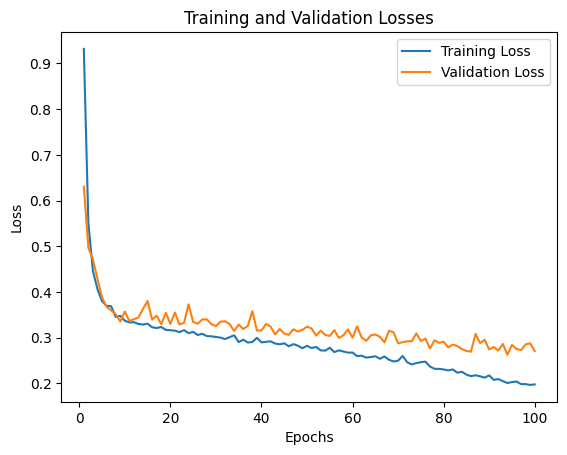

In [29]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100)

## Evaluate Neural Network Model

Report the model's accuracy on the test set.

In [30]:
# report model accuracy on test data
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    print(f"Accuracy: {correct / total}")

Accuracy: 0.8913092017173767


Just for the sake of curiosity, let's take a random sample from the test set and see the model's prediction. So, randomly choose a sample from the test set and print it out (to see its features and also the correct output). Then, feed the features into your model and see what it predicts. Is it correct?

In [31]:
import random
# choose a random sample from test data and print it out
sample = test_dataset[random.randint(0, len(test_dataset))]
sample

(tensor([0.7533, 0.6845, 0.3164, 0.0963]), tensor(6))

In [32]:
# predict the destination of the above sample
# print out the prediction
_, prediction = torch.max(model(sample[0]).data, -1)
print(f"Predicted: {prediction.item()}")

Predicted: 6


In [33]:
# print out the actual destination of the above sample
print(f"Actual: {sample[1].item()}")

Actual: 6


Now, use the inverse transform of the encoding you used earlier to get the name of the destination from the predicted class. Print it out and see if it's correct.

In [34]:
# use inverse_transform to print out the actual name of destination of the above sample
inv = label_enc.inverse_transform([sample[1].item()])
print(f"Name of predicted destination: {inv[0].split('_')[0]}")

Name of predicted destination: work


**QUESTION**: What do you think about this approach? Is it a good idea to use Neural Networks for this problem? Why (or why not)? If the patterns in our dataset (passengers' history) get more complicated, will our model be robust to it in comparison to other models?

Your Answer: It's obvious that this method was the best one for this problem, we also can see it from the accuracies. It also is so flexible and we can change our nn structure and layers to fit the input data. So overall, despite the heavy preprocessing needed to make a usable data, nn is the best and most reliable method to use.